# Welcome to RISK Quickstart

This notebook provides a minimal working example of using **RISK (Regional Inference of Significant Kinships)** to analyze biological networks.

RISK enables network clustering, functional enrichment, and high-quality visualization of biological datasets.  
Here, we demonstrate basic usage on a small example network.

For a complete walkthrough and advanced options, see the [Full Tutorial](https://riskportal.github.io/network-tutorial/tutorial.html).


In [15]:
# Import RISK
import risk as r
from risk import RISK

# Import standard libraries
import os
from pathlib import Path

# Print RISK version
print(f"RISK version: {r.__version__}")

# Set working directory if running in a Binder / notebook environment
if "__file__" not in globals():
    os.chdir(Path().resolve())

# Enable inline plotting for notebooks
%matplotlib inline

RISK version: 0.0.13-beta.4


---

## Initialize RISK

Environment configured. Ready to start analysis.

**Note:**  
You can customize RISK initialization with additional parameters (e.g., controlling verbosity, setting random seeds, etc.).


In [16]:
# Initialize the RISK object
risk = RISK(verbose=True)

---

## Load Network for RISK Analysis

Next, we load a network file into RISK for analysis.

RISK supports loading networks from multiple formats, including:

- Cytoscape files (`.cys`)
- Cytoscape JSON files (`.cyjs`)
- GPickle files (`.gpickle`)
- NetworkX graphs

In this quickstart, we demonstrate loading a Cytoscape `.cys` file.


In [17]:
# Load the network from a Cytoscape file for RISK analysis
network = risk.load_network_cytoscape(
    filepath="./data/cytoscape/michaelis_2023.cys",
    source_label="source",
    target_label="target",
    compute_sphere=True,
    surface_depth=0.1,
)

---------------
Loading network
---------------
Filetype: Cytoscape
Filepath: ./data/cytoscape/michaelis_2023.cys
Minimum edges per node: 0
Projection: Sphere
Surface depth: 0.1
Initial node count: 2059
Final node count: 2059
Initial edge count: 27690
Final edge count: 27690


---

## Load and Associate Annotations

Now we link biological annotations to the network nodes.

RISK supports loading annotations from various formats, including:

- JSON files (`.json`)
- CSV files (`.csv`)
- TSV files (`.tsv`)
- Excel spreadsheets (`.xlsx`, `.xls`)
- In-memory Python dictionaries

This quickstart demonstrates loading annotations from a JSON file.

In [18]:
# Load GO Biological Process (BP) annotations from a JSON file and associate with the network
annotation = risk.load_annotation_json(
    network=network,
    filepath="./data/json/annotation/go_biological_process.json",
    min_nodes_per_term=1,
    max_nodes_per_term=10_000,
)

------------------
Loading annotation
------------------
Filetype: JSON
Filepath: ./data/json/annotation/go_biological_process.json
Minimum number of nodes per annotation term: 1
Maximum number of nodes per annotation term: 10000
Number of input annotation terms: 2214
Number of remaining annotation terms: 1813


---

## Statistical Test for Annotation Significance

With the network and annotation ready, we test for significant patterns.

RISK supports several statistical tests for evaluating annotation enrichment or depletion:

- Permutation test
- Hypergeometric test
- Binomial test
- Chi-squared test
- Poisson test
- Z-score test

This quickstart demonstrates the permutation test, which reshuffles network structure to assess statistical significance.

In [19]:
# Perform annotation significance analysis using the permutation test
neighborhoods = risk.load_neighborhoods_permutation(
    network=network,
    annotation=annotation,
    distance_metric="louvain",
    louvain_resolution=10.0,
    leiden_resolution=1.0,
    fraction_shortest_edges=0.275,
    score_metric="stdev",
    null_distribution="network",
    num_permutations=1000,
    random_seed=887,
    max_workers=1,
)

------------------------
Running permutation test
------------------------
Neighborhood scoring metric: 'stdev'
Number of permutations: 1000
Maximum workers: 1
Null distribution: 'network'
Distance metric: 'louvain (resolution=10.0)'
Edge length threshold: 0.275
Random seed: 887


Total progress: 100%|█████████████████████████| 1000/1000 [00:15<00:00, 65.32it/s]


---

## Build and Explore the Network Graph

We now create a processed graph object integrating all previous steps.

The `load_graph` function in RISK generates a `NetworkGraph` object for analysis and visualization.  
It integrates network structure, annotation information, and statistical significance.

After building the graph, key attributes such as domain mappings and node significance scores can be accessed.

In [20]:
# Generate the NetworkGraph object for analysis
graph = risk.load_graph(
    network=network,
    annotation=annotation,
    neighborhoods=neighborhoods,
    tail="right",
    pval_cutoff=0.05,
    fdr_cutoff=1.0,
    impute_depth=0,
    prune_threshold=0.125,
    linkage_criterion="distance",
    linkage_method="single",
    linkage_metric="jaccard",
    linkage_threshold="auto",
    min_cluster_size=6,
    max_cluster_size=1000,
)

# Access important NetworkGraph attributes
domain_id_to_node_ids_map = graph.domain_id_to_node_ids_map
domain_id_to_node_labels_map = graph.domain_id_to_node_labels_map
domain_id_to_domain_terms_map = graph.domain_id_to_domain_terms_map
node_label_to_significance_map = graph.node_label_to_significance_map

---------------------------------
Finding significant neighborhoods
---------------------------------
p-value cutoff: 0.05
FDR BH cutoff: 1.0
Significance tail: 'right' (enrichment)
------------------------
Processing neighborhoods
------------------------
Imputation depth: 0
Pruning threshold: 0.125
-----------------------
Finding top annotations
-----------------------
Min cluster size: 6
Max cluster size: 1000
-----------------------------------------
Optimizing distance threshold for domains
-----------------------------------------


Evaluating linkage methods and metrics: 100%|██████████████████| 1/1 [00:07<00:00]


Linkage criterion: 'distance'
Linkage method: 'single'
Linkage metric: 'jaccard'
Linkage threshold: 0.001


---

## Summarize Analysis Results

The `summary.load()` method processes network annotations and significance scores into a pandas DataFrame for exploration.

In [21]:
# Load analysis summary into a DataFrame
loaded_summary = graph.summary.load()
loaded_summary.head()

------------------------
Loading analysis summary
------------------------


,Annotation,Domain ID,Annotation Members in Network,Annotation Members in Network Count,Summed Significance Score,Enrichment P-Value,Enrichment Q-value,Depletion P-Value,Depletion Q-value
0,negative regulation of meiotic cell cycle phas...,-1,,0,0.000000,1.000,1.0,1.0,1.0
1,maintenance of protein location in cell,-1,,0,0.000000,1.000,1.0,1.0,1.0
2,positive regulation of G2/M transition of mito...,-1,,0,0.000000,1.000,1.0,1.0,1.0
3,negative regulation of pheromone-dependent sig...,109,AKR1,1,68.044372,0.018,1.0,1.0,1.0
4,mRNA splice site recognition,-1,,0,0.000000,1.000,1.0,1.0,1.0


---

## Visualize the Network

Finally, let's visualize the clustered network!

RISK provides flexible plotting tools to visualize clustered biological networks.  
In this example, we customize:

- Background color and figure size
- Network title and subtitle
- Network perimeter (circle)
- Node and edge styles
- Labels for major clusters

We group all these steps into a single clean plot.

---------------
Loading plotter
---------------


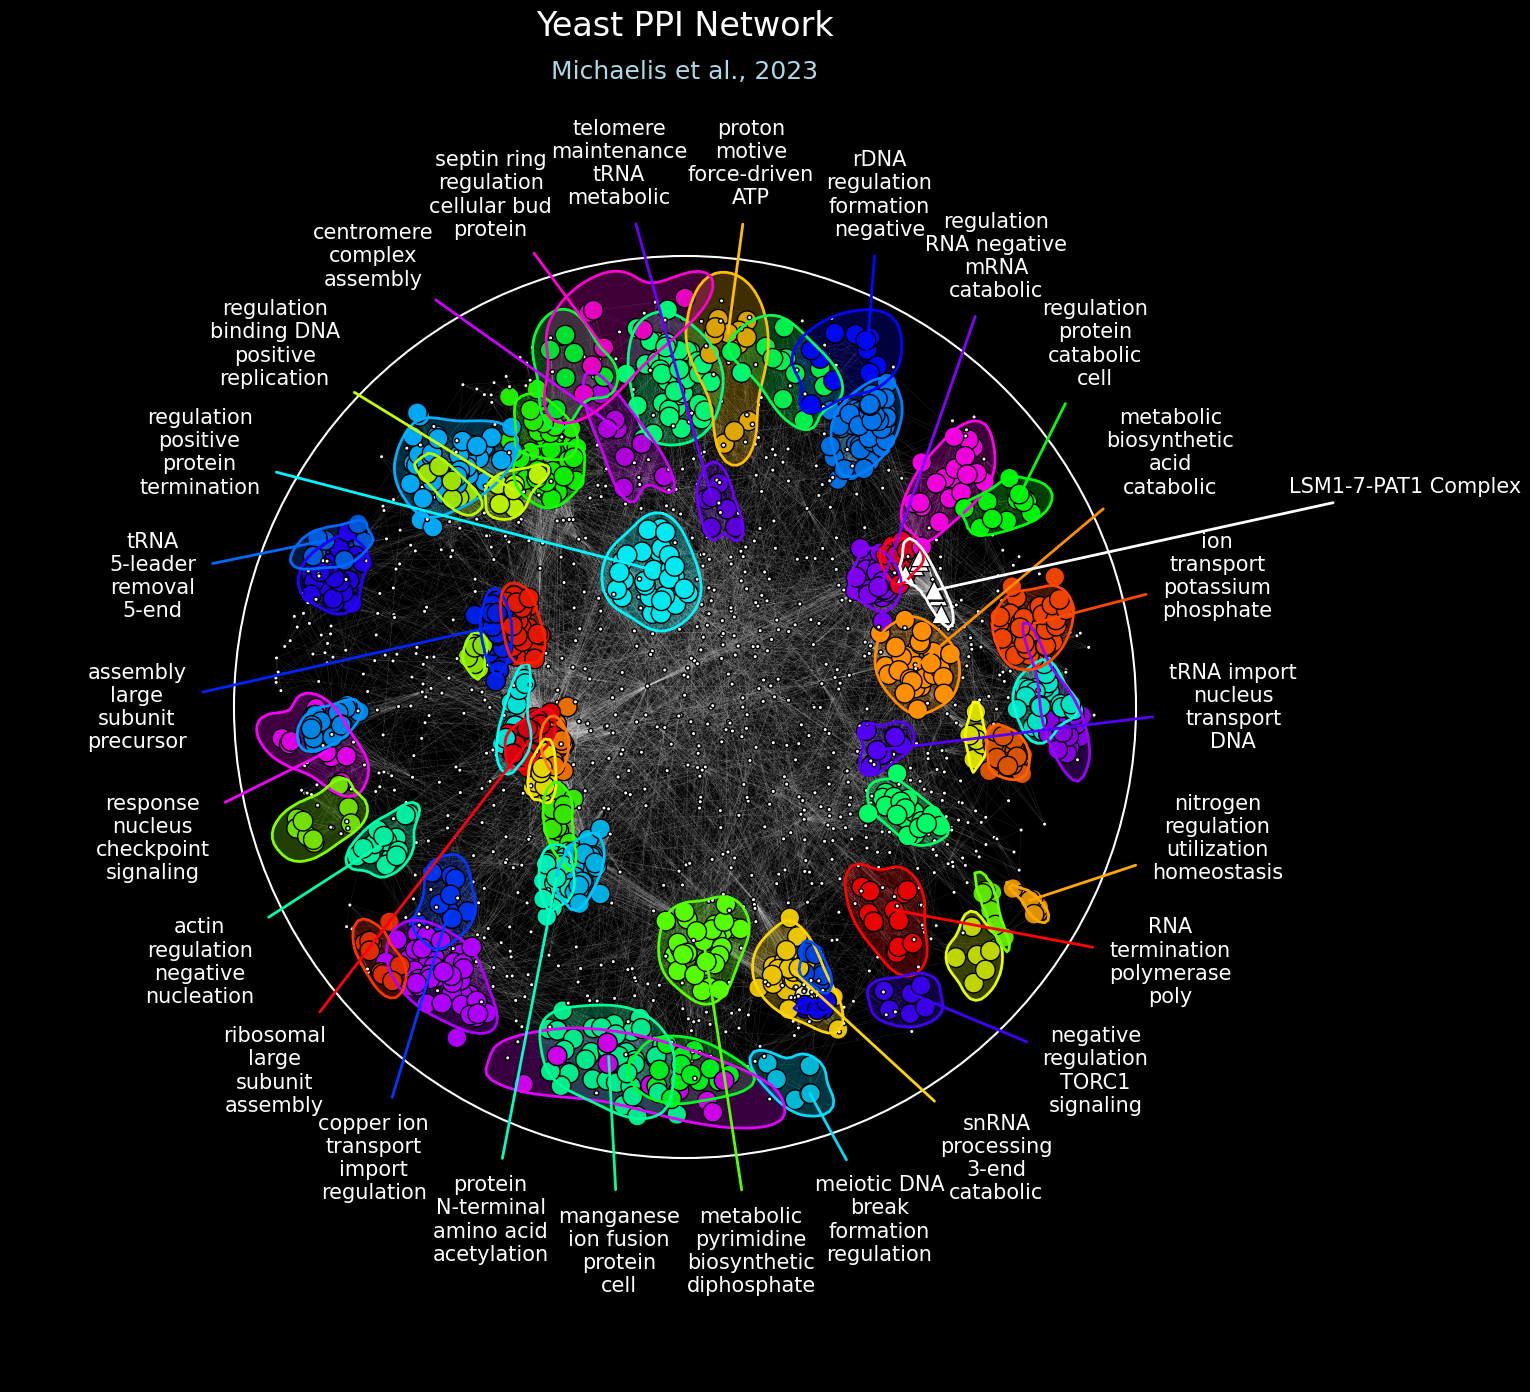

In [22]:
# Build full network plot
import matplotlib.pyplot as plt

plt.ioff()

# Set random seed for reproducibility
random_seed = 887

# Initialize the NetworkPlotter with the NetworkGraph object
plotter = risk.load_plotter(
    graph=graph,
    figsize=(15, 15),
    background_color="black",
)

# Plot network title and subtitle
plotter.plot_title(
    title="Yeast PPI Network",
    subtitle="Michaelis et al., 2023",
    title_fontsize=24,
    subtitle_fontsize=18,
    font="DejaVu Sans",
    title_color="white",
    subtitle_color="lightblue",
    title_x=0.5,
    title_y=0.925,
    title_space_offset=0.08,
    subtitle_offset=0.025,
)

# Plot network perimeter as a circle
plotter.plot_circle_perimeter(
    scale=1.05,
    center_offset_x=0.0,
    center_offset_y=0.0,
    linestyle="solid",
    linewidth=1.5,
    color="white",
    outline_alpha=1.0,
    fill_alpha=0.0,
)

# Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=200,
        nonsignificant_size=10,
    ),
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.04,
    node_color=plotter.get_annotated_node_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=0.8,
        max_scale=1.0,
        scale_factor=0.5,
        alpha=1.0,
        nonsignificant_color="white",
        nonsignificant_alpha=0.75,
        ids_to_colors=None,
        random_seed=random_seed,
    ),
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# Plot a subnetwork with custom node and edge attributes
plotter.plot_subnetwork(
    nodes=[
        "LSM1",
        "LSM2",
        "LSM3",
        "LSM4",
        "LSM5",
        "LSM6",
        "LSM7",
        "PAT1",
    ],
    node_size=200,
    node_shape="^",
    node_edgewidth=1.0,
    edge_width=0.04,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# Plot KDE-based contours around network nodes
plotter.plot_contours(
    levels=5,
    bandwidth=0.8,
    grid_size=250,
    color=plotter.get_annotated_contour_colors(
        cmap="gist_rainbow",
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        ids_to_colors=None,
        random_seed=random_seed,
    ),
    linestyle="solid",
    linewidth=2.0,
    alpha=1.0,
    fill_alpha=0.25,
)

# Plot custom KDE-based contours around a subset of nodes
plotter.plot_subcontour(
    nodes=[
        "LSM1",
        "LSM2",
        "LSM3",
        "LSM4",
        "LSM5",
        "LSM6",
        "LSM7",
        "PAT1",
    ],
    levels=5,
    bandwidth=0.8,
    grid_size=250,
    color="white",
    linestyle="solid",
    linewidth=2.0,
    alpha=1.0,
    fill_alpha=0.25,
)

# Plot labels on the network
plotter.plot_labels(
    scale=1.1,
    offset=0.12,
    font="DejaVu Sans",
    fontcase={"title": "lower"},
    fontsize=15,
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=2.0,
    arrow_style="-",
    arrow_color=plotter.get_annotated_label_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        ids_to_colors=None,
        random_seed=random_seed,
    ),
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
    max_labels=28,
    min_label_lines=3,
    max_label_lines=4,
    min_chars_per_line=3,
    max_chars_per_line=12,
    words_to_omit=["from", "the", "into", "via", "novo", "process", "activity"],
    overlay_ids=False,
    ids_to_keep=None,
    ids_to_labels=None,
)

# Plot sublabels on the network
plotter.plot_sublabel(
    nodes=[
        "LSM1",
        "LSM2",
        "LSM3",
        "LSM4",
        "LSM5",
        "LSM6",
        "LSM7",
        "PAT1",
    ],
    label="LSM1-7-PAT1 Complex",
    radial_position=73,
    scale=1.6,
    offset=0.12,
    font="DejaVu Sans",
    fontsize=15,
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=2.0,
    arrow_style="-",
    arrow_color="white",
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
)

# Display the plot
plotter.show()

---

## Overview of Parameters

RISK automatically tracks key parameters used during analysis, including network settings, annotation details, statistical test settings, and plotting configurations.

You can view and export these parameters to document or share your analysis settings.

In [23]:
# Load and display RISK parameters
import pandas as pd
from IPython.display import display

loaded_params = risk.params.load()

# Display parameters in a tidy table
pd.set_option("display.max_colwidth", 200)
display(pd.DataFrame(list(loaded_params.items()), columns=["Parameter", "Value"]))
pd.reset_option("display.max_colwidth")

------------------
Loading parameters
------------------


,Parameter,Value
0,annotation,"{'filetype': 'JSON', 'filepath': './data/json/annotation/go_biological_process.json', 'min_nodes_per_term': 1, 'max_nodes_per_term': 10000}"
1,datetime,2025-05-03 10:10:24
2,graph,"{'tail': 'right', 'pval_cutoff': 0.05, 'fdr_cutoff': 1.0, 'impute_depth': 0, 'prune_threshold': 0.125, 'linkage_criterion': 'distance', 'linkage_method': 'single', 'linkage_metric': 'jaccard', 'li..."
3,neighborhoods,"{'distance_metric': 'louvain', 'louvain_resolution': 10.0, 'leiden_resolution': 1.0, 'fraction_shortest_edges': 0.275, 'statistical_test_function': 'permutation', 'null_distribution': 'network', '..."
4,network,"{'compute_sphere': True, 'surface_depth': 0.1, 'min_edges_per_node': 0, 'filetype': 'Cytoscape', 'filepath': './data/cytoscape/michaelis_2023.cys'}"
5,plotter,"{'figsize': (15, 15), 'background_color': 'black', 'background_alpha': 1.0, 'pad': 0.3, 'title': 'Yeast PPI Network', 'subtitle': 'Michaelis et al., 2023', 'title_fontsize': 24, 'subtitle_fontsize..."


---

## Advanced Visualization

RISK also supports advanced visualizations, including:

- Highlighting specific subnetworks (e.g., protein complexes, coexpression clusters)
- Custom labeling and contour plotting
- Overlaying multiple biological datasets on a single network

Congratulations! You've completed the RISK Quickstart. Explore more in the [Full Tutorial](https://riskportal.github.io/network-tutorial/tutorial.html).
